# Gaussian Density Filtering for predicting mid-price raise in LOBs

In this notebook we present results of prediction if the mid price will raise in next tick for LOBs. For data preparation we use GDF filters with various parameters $r$ and $\sigma$.

For prediction we use SVM - we will use 4 features for predictions, which will be described in later parts.
We will refer to this approach as `GDF+SVM` approach. We compare our results to approach which used logistic regression and queue imbalance as features. We will refer to this approach as `logit+queue-imbalance`.

The order is as follows:

1. Data description
2. Methodology
    * GDF parameteres choice
3. Results
    * `GDF+SVM` validation vs training set results
    * `logit+queue-imbalance` vs `GDF+SVM` on training set
    * `logit+queue-imbalance` vs `GDF+SVM` on validation set
    * test set results
4. Conclusions

In [1]:
%matplotlib inline
from ast import literal_eval
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from typing import Tuple
import numpy as np
import itertools
import os
from collections import OrderedDict

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from scipy.stats import norm

import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go

import warnings

from lob_data_utils import lob, db_result, roc_results

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')
py.init_notebook_mode(connected=True)

## Data

We use data from 2013-09 till 2013-11 from 53 stocks which have at least 10000 datapoints - we use exactly 10000 datapoints. First we normalize the data, then we apply GDF filters (described in `gdf_approach_description.ipynb` notebook). For GDF filters we need to choose parameters:

* $\sigma$ - how wide is the Gaussian curve
* $r$ - how tall is the Gaussian curve
* $K$ - on how many segments we will divide the data

We have choosen:
* $\sigma \in \{0.1, 0.2, 0.3, 0.4, 0.5\} $
* $r \in \{ 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 \}$
* K = 50

We used grid approach, so we generated the data for every pair of the parameters $r$ and $\sigma$.

We split data into three continous datasets:
* training data - 60% of datapoints
* validation data - 20% of datapoints
* testing data - 20% of datapoints

In [7]:
r = 0.5
s = 0.1
stock = '11234'
K = 50
length = 10000
filename = 'data_gdf_z_score/gdf_{}_len{}_r{}_s{}_K{}.csv'.format(stock, length, r, s, K)
df_data_example = pd.read_csv(filename)
df_data_example.head()

FileNotFoundError: File b'data_gdf_z_score/gdf_11234_len10000_r0.5_s0.1_K50.csv' does not exist

In [6]:
gdf_columns = ['gdf_' + str(i) for i in range(0, 50)]

plt.figure(figsize=(16, 8))
ax = sns.boxplot(df_data_example[gdf_columns])

_ = ax.set_xticklabels(gdf_columns, rotation=45)

plt.title('Distribution of gdf features for stock ' + str(stock))
plt.xlabel('GDF feature')
plt.ylabel('ValueError')

NameError: name 'df_data_example' is not defined

<Figure size 1152x576 with 0 Axes>

In [4]:
gdf_features_columns = ['gdf_' + str(i) for i in range(23, 27)]
df_data_example[gdf_features_columns].iloc[0:50].plot(figsize=(16,8), marker='.', alpha=0.5)
plt.title('Gdf features')
plt.xlabel('GDF feature')
plt.ylabel('value')

NameError: name 'df_data_example' is not defined

## Methodology

### Methodology for `GDF+SVM` approach:

First we need to find a way to prepare data to perform classsification, right choice of parameters:
* $\sigma \in \{0.1, 0.2, 0.3, 0.4, 0.5\} $
* $r \in \{ 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 \}$
is crucial.

After that we train SVM with `rbf` kernel on the *training* set applied GDF filters with choosen $\sigma$ and $r$ parameters. Next we hypertune `gamma` and `C` parameters on *validation* dataset. After that we pick the best parameters for training algorithm and test how it performs on *testing* dataset.

In this notebook we pick 10 features for prediction `gdf_i` for $i \in [20, 21, \ldots, 30]$ obtained by applying **GDF** to the datasets. They are choosen, because they don't have so wide spread of values as the rest and they are in the "middle".

For choosing the SVM parameters we will use grid-search approach with parameters:
* $\gamma \in (1, 10, 100, 1000, 10000)$
* $ C \in (1, 10, 100, 1000, 10000)$
                
We will use **ROC area score** for evaluating the performance of the classifiers. We will compare our results to results obtained by using `logit+queue-imbalance` *logistic regression* with **queue imbalance** feature (which was described in ealier work).

In [5]:
s_parameters = [0.1, 0.2, 0.3, 0.4, 0.5]
r_parameters = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
length = 10000
stocks = list(roc_results.results_10000.keys())
K1 = 20
K2 = 30
K = 50

df_res = pd.DataFrame()
for r in r_parameters:
    for s in s_parameters:
        for stock in stocks:
            try:
                filename = 'data_res/res_{}_len{}_r{}_s{}_K{}-{}.csv'.format(stock, length, r, s, K1, K2)
                df = pd.read_csv(filename)
                df_res = df_res.append(df, ignore_index=True)
            except Exception as e:
                pass
df_res.drop('Unnamed: 0', axis=1, inplace=True)
df_res = df_res.apply(pd.to_numeric)
df_res.dropna(axis=0, inplace=True)

df_res.head()

,C,K,gamma,r,roc_cv,roc_train,s,stock
1,1,50,10,0.01,0.509725,0.542784,0.1,9069
2,1,50,100,0.01,0.521034,0.547078,0.1,9069
3,1,50,1000,0.01,0.517718,0.558361,0.1,9069
4,1,50,10000,0.01,0.525678,0.644563,0.1,9069
5,10,50,1,0.01,0.504882,0.541404,0.1,9069


In [6]:
stocks = list(df_res['stock'].unique())
print('Number of stocks in datasets:', len(stocks))

Number of stocks in datasets: 53


#### Results dataset

We introduce dataframe with results which will have columns:
* `stock` - stock id
* `K` - number of segments for GDF filters
* `s` - $\sigma$ parameter for GDF filters
* `r` - scale parameter for GDF filters
* `C` - C parameter for `GDF_SVM`
* `gamma` - $\gamma$ parameter for `GDF_SVM`
* `roc_cv` - ROC area score for `GDF_SVM`(r, s, K, C, gamma) on validation set
* `roc_train` - ROC area score for `GDF_SVM`(r, s, K, C, gamma) on training set
* `roc_log_cv` - ROC area score for `logit+queue-imbalance` on validation set
* `roc_log_train` - ROC area score for `logit+queue-imbalance` on training set
* `roc_cv_diff` - ROC area score difference between `GDF_SVM` and `logit+queue-imbalance` on validation set
* `roc_train_diff` - ROC area score difference between `GDF_SVM` and `logit+queue-imbalance` on training set
* `cv_train_diff` - ROC area score difference for `GDF_SVM` between result on validation and training set

In [7]:
df_res['roc_log_cv'] = np.zeros(len(df_res)) - 1
df_res['roc_log_train'] = np.zeros(len(df_res)) - 1
roc_log_cv = []
res_log = roc_results.result_cv_10000
for idx, row in df_res.iterrows():
    roc_log_cv.append(res_log[str(int(row['stock']))])
df_res['roc_log_cv'] = roc_log_cv

roc_log_train = []
res_log = roc_results.results_10000
for idx, row in df_res.iterrows():
    roc_log_train.append(res_log[str(int(row['stock']))])
df_res['roc_log_train'] = roc_log_train

df_res['roc_cv_diff'] = df_res['roc_cv'] - df_res['roc_log_cv']
df_res['roc_train_diff'] = df_res['roc_train'] - df_res['roc_log_train']
df_res['cv_train_diff'] = df_res['roc_cv'] - df_res['roc_train']

df_res.head()

,C,K,gamma,r,roc_cv,roc_train,s,stock,roc_log_cv,roc_log_train,roc_cv_diff,roc_train_diff,cv_train_diff
1,1,50,10,0.01,0.509725,0.542784,0.1,9069,0.546371,0.538344,-0.036646,0.004439,-0.033059
2,1,50,100,0.01,0.521034,0.547078,0.1,9069,0.546371,0.538344,-0.025337,0.008733,-0.026044
3,1,50,1000,0.01,0.517718,0.558361,0.1,9069,0.546371,0.538344,-0.028653,0.020017,-0.040643
4,1,50,10000,0.01,0.525678,0.644563,0.1,9069,0.546371,0.538344,-0.020693,0.106219,-0.118885
5,10,50,1,0.01,0.504882,0.541404,0.1,9069,0.546371,0.538344,-0.041489,0.003060,-0.036523


### Paramters for GDF filters

In this section we want to analyze the influence of the choice of the $r$ and $\sigma$ parameters on the quality of predictions. The $r$ and $\sigma$ parameters are used in the data preparation stage to calculate gdf features ($r$ is how tall is gaussian curve, $\sigma$ is how wide it is).

We prepared the datasets with all pairs of these parameters:
* $\sigma \in \{0.1, 0.2, 0.3, 0.4, 0.5\} $
* $r \in \{ 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 \}$

Noisy plot below presents the distributions of the **ROC area scores** for different pairs of $r$ and $\sigma$ parameters. We can observe that the first quartle (Q1) has bigger values when $\sigma$ (`s` on the picture) is smaller.

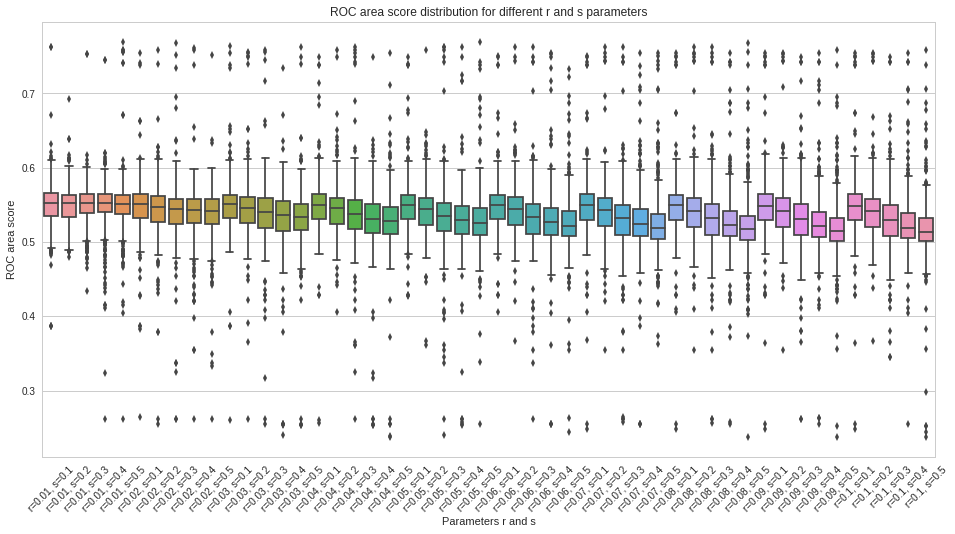

In [8]:
r_s_dict = OrderedDict()

for r in r_parameters:
    for s in s_parameters:
        r_s_dict['r={}, s={}'.format(r, s)] = df_res[df_res['r'] == r][df_res['s'] == s]['roc_cv'].values

plt.figure(figsize=(16, 8))
ax = sns.boxplot(data=list(r_s_dict.values()))
plt.ylabel('ROC area score')
plt.xlabel('Parameters r and s')
_ = ax.set_xticklabels(list(r_s_dict.keys()), rotation=45)
plt.title('ROC area score distribution for different r and s parameters')

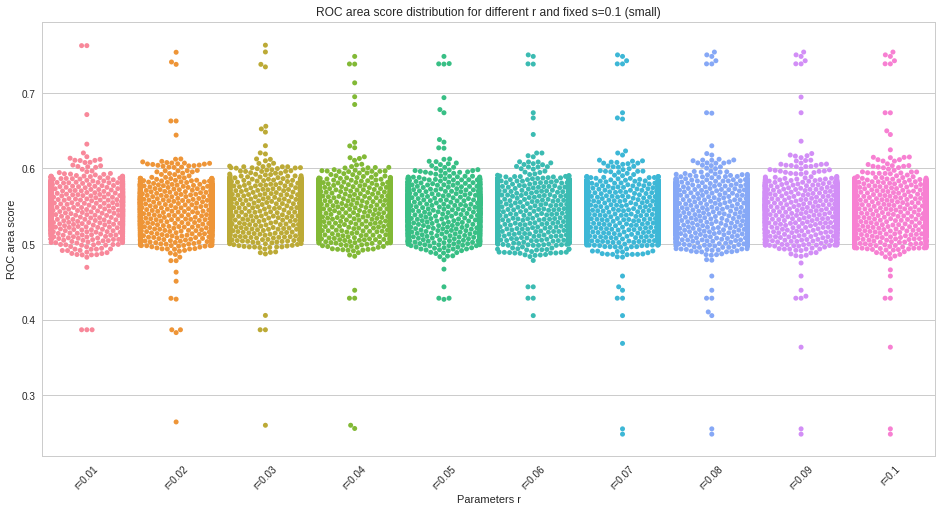

In [9]:
r_s_dict = OrderedDict()

for r in r_parameters:
    for s in [0.1]:
        r_s_dict['r={}'.format(r, s)] = df_res[df_res['r'] == r][df_res['s'] == s]['roc_cv'].values

plt.figure(figsize=(16, 8))
ax = sns.swarmplot(data=list(r_s_dict.values()))
plt.ylabel('ROC area score')
plt.xlabel('Parameters r')
_ = ax.set_xticklabels(list(r_s_dict.keys()), rotation=45)
plt.title('ROC area score distribution for different r and fixed s=0.1 (small)')

There doesn't seem to be a big difference between different $r$ parameters when the $\sigma$ parameter is small. Anyway we can check also programmatically what is the best using two metrics:

* number of stocks which have worse results than `logit+queue-imbalance` on validation set
* mean of ROC area scores on validation set (the highest will be considered the best)

We could also calculate sums of mean errors on validation/training scores, but we prefer to have more "generalized" approach, which will bring improvement for all stocks.

#### Number of stocks which have worse results than `logit+queue-imbalance` on validation set

We will check for how many stocks we underperformed and we will pick $r$ and $\sigma$ for which this number is the smallest one. We will compare our `GDF+SVM` against **logit queue-imbalance** approach.

In [10]:
number_of_worse = []
for s in s_parameters:
    for r in r_parameters:
        df_r_s = df_res[df_res['s'] == s][df_res['r'] == r]
        df_r_s = df_r_s.sort_values(by='roc_cv_diff', ascending=False)
        df_r_s = df_r_s.groupby(by='stock').apply(lambda df: df.nlargest(1, columns=['roc_cv_diff']))
        worse_num = len(df_r_s[df_r_s['roc_cv_diff'] < 0])
        number_of_worse.append({'s': s, 'r': r, 'worse_num': worse_num})

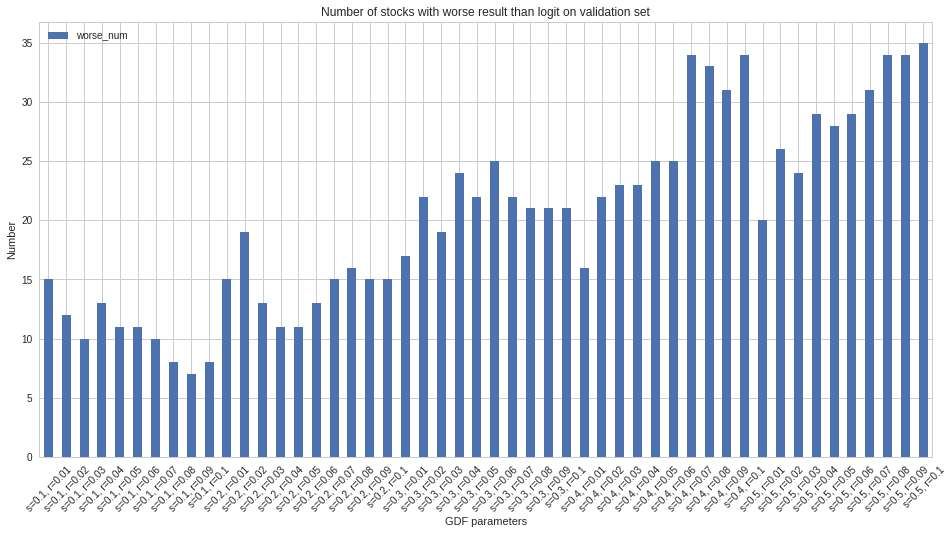

In [11]:
df_worse_num = pd.DataFrame(number_of_worse)

ax = df_worse_num[['worse_num']].plot(kind='bar', figsize=(16,8))
ax_cols = ['s={}, r={}'.format(v[0], v[1])  for v in df_worse_num[['s', 'r']].values]
_ = ax.set_xticklabels(ax_cols, rotation=45)
plt.title('Number of stocks with worse result than logit on validation set')
plt.ylabel('Number')
plt.xlabel('GDF parameters')

In [12]:
print('The best parameters are:')
best_gdf_parameters = df_worse_num.nsmallest(1, columns=['worse_num'])
best_gdf_parameters

The best parameters are:


,r,s,worse_num
8,0.09,0.1,7


Looking at the whole results data set with the best parameters above we **underperform by 0.1%** on average, with **standard deviation 3%** (in `roc_cv_diff` column we have *difference* between `GDF+SVM` approach scores versus `logit+queue-imbalance`). This result is not bad since we look at all trained classifiers scores instead. It means that hypertunning SVM parameters is a good next step to have an improvement.

In [13]:
df_res_fixed = df_res[df_res['s'] == best_gdf_parameters.iloc[0]['s']][df_res['r'] == 
                                                                       best_gdf_parameters.iloc[0]['r']]
df_res_fixed = df_res_fixed.sort_values(by='roc_cv_diff', ascending=False)
df_res_fixed[['roc_cv', 'roc_train', 'roc_log_train', 'roc_log_cv', 'roc_cv_diff']].describe()

,roc_cv,roc_train,roc_log_train,roc_log_cv,roc_cv_diff
count,1306.000000,1306.000000,1306.000000,1306.000000,1306.000000
mean,0.546870,0.625240,0.563252,0.557121,-0.010251
std,0.031706,0.109737,0.013410,0.014519,0.031851
min,0.248374,0.334168,0.531468,0.528266,-0.316940
25%,0.528874,0.562821,0.557195,0.548715,-0.028644
50%,0.548344,0.580339,0.564725,0.556133,-0.009798
75%,0.564484,0.631668,0.574662,0.564415,0.009041
max,0.754127,1.000000,0.584326,0.600882,0.214356


##### Stocks for which we underperform:

In [14]:
df_bests_fixed = df_res_fixed.sort_values(by='roc_cv', ascending=False)

df_bests_fixed = df_bests_fixed.groupby(by='stock').apply(lambda df: df.nlargest(1, columns=['roc_cv_diff']))
df_bests_fixed = df_bests_fixed.sort_values(by='roc_cv', ascending=False)
print('Number of worse stocks', len(df_bests_fixed[df_bests_fixed['roc_cv_diff'] < 0]), 'per', 
     len(df_bests_fixed['stock'].unique()))
df_worst_fixed = df_bests_fixed[df_bests_fixed['roc_cv_diff'] < 0]
df_worst_fixed

Number of worse stocks 7 per 53


,,C,K,gamma,r,roc_cv,roc_train,s,stock,roc_log_cv,roc_log_train,roc_cv_diff,roc_train_diff,cv_train_diff
stock,,,,,,,,,,,,,,
7858,53472,10000,50,100,0.09,0.585448,0.592518,0.1,7858,0.585866,0.572104,-0.000418,0.020414,-0.007070
11946,54260,100,50,1,0.09,0.585156,0.591155,0.1,11946,0.600882,0.581297,-0.015726,0.009858,-0.005999
1113,53352,1,50,100,0.09,0.559405,0.551620,0.1,1113,0.576817,0.568793,-0.017412,-0.017173,0.007784
9065,53855,10,50,1,0.09,0.557843,0.549115,0.1,9065,0.563017,0.562425,-0.005174,-0.013311,0.008728
9266,54108,10,50,1000,0.09,0.548661,0.571275,0.1,9266,0.550025,0.543751,-0.001364,0.027524,-0.022613
9069,53022,10000,50,100,0.09,0.536160,0.581515,0.1,9069,0.546371,0.538344,-0.010211,0.043171,-0.045355
9062,53428,1,50,1000,0.09,0.534712,0.548577,0.1,9062,0.552745,0.533872,-0.018033,0.014704,-0.013865


#### Mean of `roc_cv` scores

We will check for which parameters $r$ and $\sigma$ we have the highest mean of ROC area scores on validation set.

In [15]:
roc_cv_means = []
for s in s_parameters:
    for r in r_parameters:
        df_r_s = df_res[df_res['s'] == s][df_res['r'] == r]
        df_r_s = df_r_s.sort_values(by='roc_cv_diff', ascending=False)
        roc_cv_mean = df_r_s['roc_cv'].mean()
        roc_cv_means.append({'s': s, 'r': r, 'roc_cv_mean': roc_cv_mean})

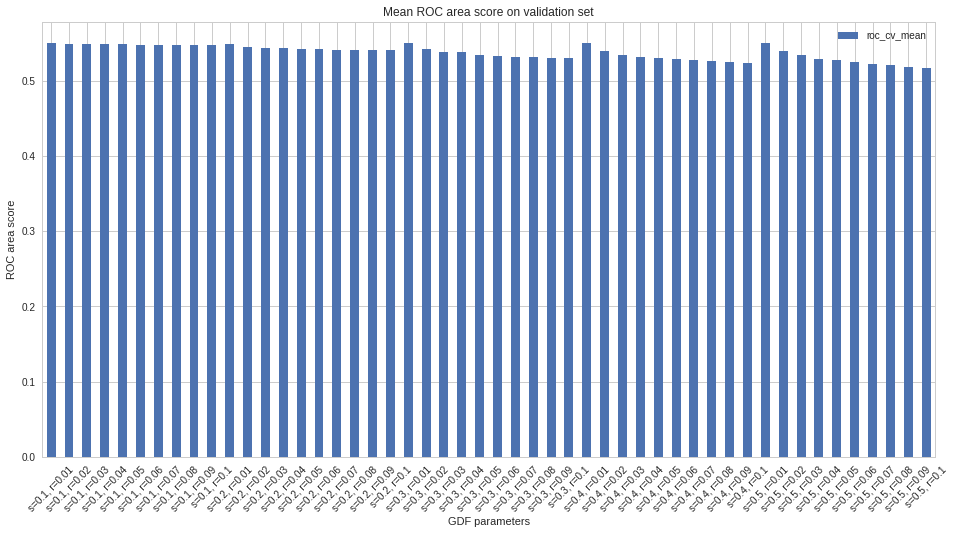

In [16]:
df_roc_cv_means = pd.DataFrame(roc_cv_means)
ax = df_roc_cv_means[['roc_cv_mean']].plot(kind='bar', figsize=(16,8))
ax_cols = ['s={}, r={}'.format(v[0], v[1])  for v in df_roc_cv_means[['s', 'r']].values]
_ = ax.set_xticklabels(ax_cols, rotation=45)
plt.title('Mean ROC area score on validation set')
plt.ylabel('ROC area score')
plt.xlabel('GDF parameters')

In [17]:
print('The best parameters are:')
best_gdf_parameters_mean = df_roc_cv_means.nlargest(3, columns=['roc_cv_mean'])
best_gdf_parameters_mean

The best parameters are:


,r,roc_cv_mean,s
0,0.01,0.550205,0.1
30,0.01,0.550133,0.4
20,0.01,0.550131,0.3


In [18]:
df_res_fixed_mean = df_res[df_res['s'] == best_gdf_parameters_mean.iloc[0]['s']][df_res['r'] == 
                                                                       best_gdf_parameters_mean.iloc[0]['r']]
df_res_fixed_mean = df_res_fixed_mean.sort_values(by='roc_cv_diff', ascending=False)
df_res_fixed_mean[['roc_cv', 'roc_train', 'roc_log_train', 'roc_log_cv', 'roc_cv_diff']].describe()

,roc_cv,roc_train,roc_log_train,roc_log_cv,roc_cv_diff
count,1273.000000,1273.000000,1273.000000,1273.000000,1273.000000
mean,0.550205,0.606448,0.563244,0.557103,-0.006897
std,0.025692,0.084604,0.013448,0.014504,0.026451
min,0.386523,0.517608,0.531468,0.528266,-0.159329
25%,0.535217,0.561702,0.557195,0.548715,-0.024155
50%,0.551915,0.576385,0.564725,0.556133,-0.005970
75%,0.565555,0.605901,0.574662,0.564415,0.011532
max,0.762631,1.000000,0.584326,0.600882,0.189092


We will use this approach (maximizing mean) for results.

In [19]:
df_res_fixed = df_res_fixed_mean

## Results

If the parameters $r$ and $\sigma$ for `GDF+SVM` approach are choosen not carefully, we can get too good scores on training and validation set. Trainig and validation set scores can be odd - one can be very high, when the other can be less than 0.5 (null-hypothesis). It means that this approach is prone to **overfitting** and we need to be careful with choosing parameters.

In [20]:
df_bests = df_res_fixed.sort_values(by='roc_cv', ascending=False)

df_bests = df_bests.groupby(by='stock').first()
df_bests = df_bests.sort_values(by='roc_cv')
df_bests.head()

,C,K,gamma,r,roc_cv,roc_train,s,roc_log_cv,roc_log_train,roc_cv_diff,roc_train_diff,cv_train_diff
stock,,,,,,,,,,,,
9069,10000,50,1000,0.01,0.533878,0.668854,0.1,0.546371,0.538344,-0.012493,0.130510,-0.134976
9062,100,50,100,0.01,0.537197,0.551168,0.1,0.552745,0.533872,-0.015547,0.017295,-0.013970
1431,100,50,10,0.01,0.538802,0.565111,0.1,0.561928,0.546492,-0.023126,0.018620,-0.026309
4618,10,50,1000,0.01,0.538869,0.572262,0.1,0.549917,0.544251,-0.011048,0.028011,-0.033393
9058,100,50,100,0.01,0.545333,0.562151,0.1,0.535500,0.547275,0.009833,0.014877,-0.016818


### Results `GDF+SVM` : training vs validation set

`GDF+SVM` performs very similar on training and validation set.

Mean square error: 0.0267347748311


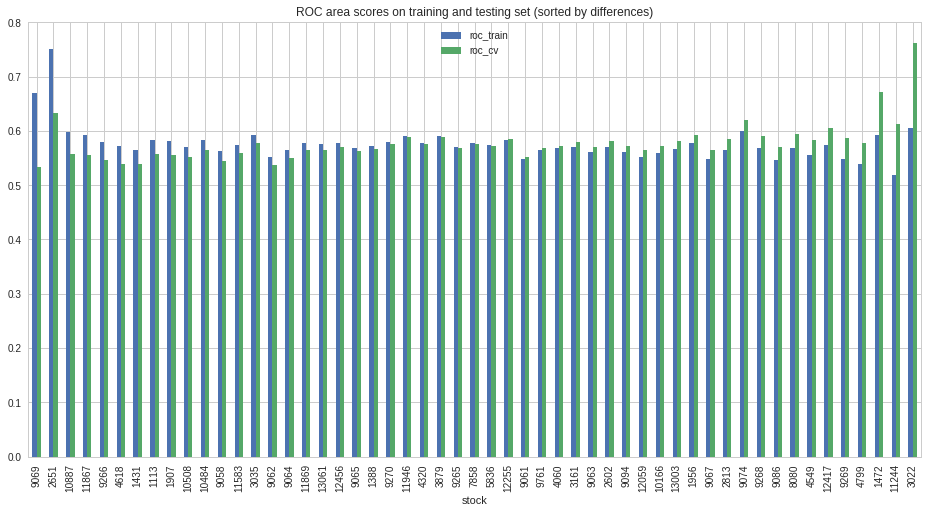

In [21]:
dff = df_bests[['roc_train', 'roc_cv', 'cv_train_diff']].sort_values(by='cv_train_diff')
dff = dff.sort_values(by=['cv_train_diff'])

dff[['roc_train', 'roc_cv']].plot(kind='bar', figsize=(16, 8))

plt.legend()
plt.title('ROC area scores on training and testing set (sorted by differences)')
print('Mean square error:', dff['cv_train_diff'].sum() / 2)

### Results `GDF+SVM` vs `logit+queue-imbalance` on training set

In about 6% cases `GDF+SVM` performs better on training set than `logit+queue-imbalance`.

Mean square error: 0.34006907886


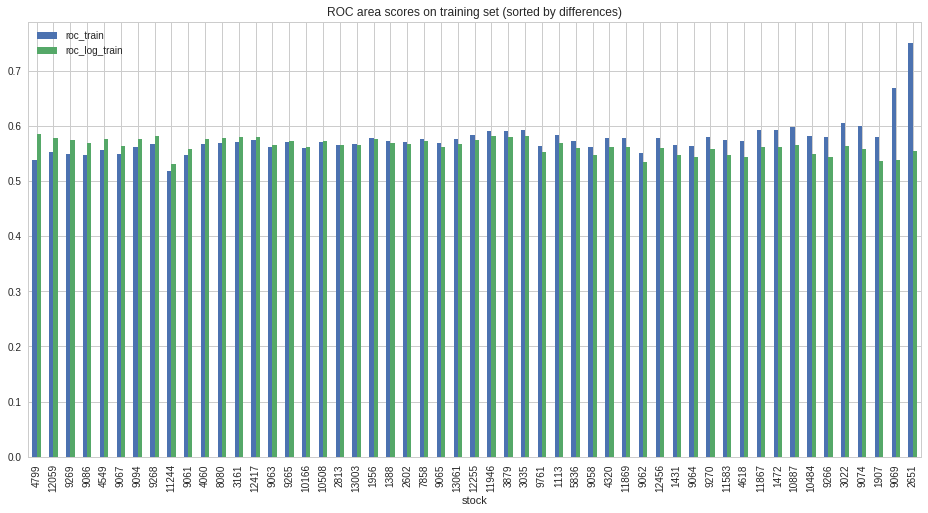

In [22]:
dff = df_bests[['roc_train', 'roc_log_train', 'roc_train_diff']].sort_values(by='roc_train_diff')

dff[['roc_train', 'roc_log_train']].plot(kind='bar', figsize=(16, 8))

plt.legend()
plt.title('ROC area scores on training set (sorted by differences)')
print('Mean square error:', dff['roc_train_diff'].sum() / 2)

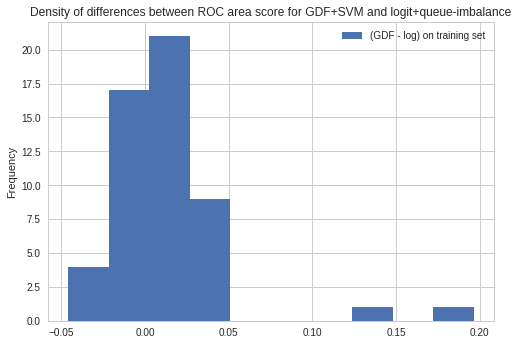

In [23]:
dff['gdf_log_train_diff'] = dff['roc_train'] - dff['roc_log_train']
dff['gdf_log_train_diff'].plot(kind='hist', label='(GDF - log) on training set')
plt.legend()
plt.title('Density of differences between ROC area score for GDF+SVM and logit+queue-imbalance')

Number of undreperforming stocks on training set: 19


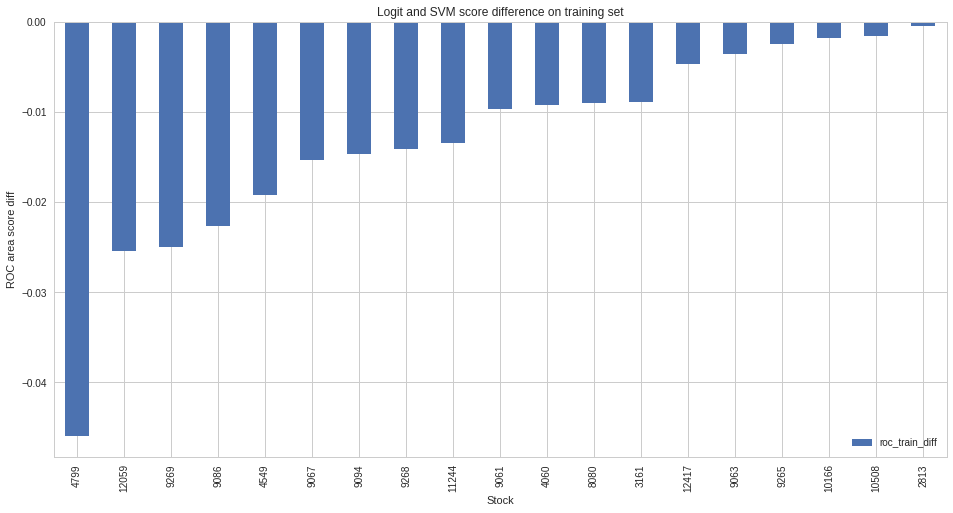

In [24]:
df_worse_train = df_bests[df_bests['roc_train'] < df_bests['roc_log_train']]

df_worse_train = df_worse_train.sort_values(by='roc_train_diff')

ax = df_worse_train[['roc_train_diff']].plot(kind='bar', figsize=(16,8))
print('Number of undreperforming stocks on training set:', len(df_worse_train))
plt.title('Logit and SVM score difference on training set')
plt.ylabel('ROC area score diff')
plt.xlabel('Stock')

### Results `GDF+SVM` vs `logit+queue-imbalance` on validation set

`GDF+SVM` approach performs better on validation set on most of the stocks.

Mean square error: 0.528811635219


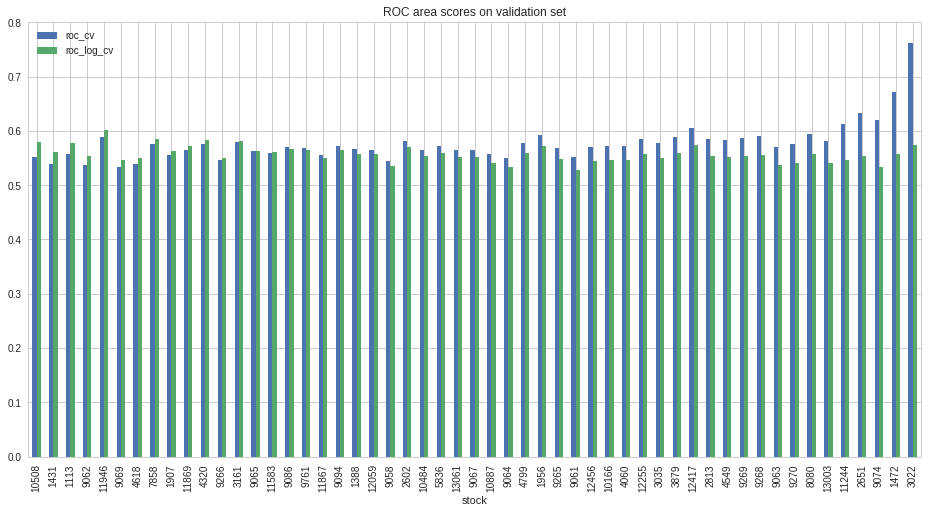

In [25]:
dff = df_bests[['roc_cv', 'roc_log_cv', 'roc_cv_diff']].sort_values(by='roc_cv_diff')

dff[['roc_cv', 'roc_log_cv']].plot(kind='bar', figsize=(16, 8))

plt.legend()
plt.title('ROC area scores on validation set')

print('Mean square error:', dff['roc_cv_diff'].sum() / 2)

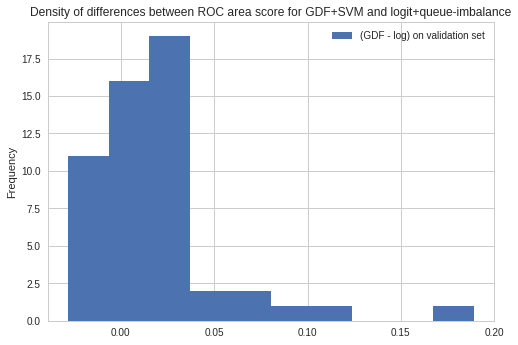

In [26]:
dff['gdf_log_cv_diff'] = dff['roc_cv'] - dff['roc_log_cv']
dff['gdf_log_cv_diff'].plot(kind='hist', label='(GDF - log) on validation set')
plt.legend()
plt.title('Density of differences between ROC area score for GDF+SVM and logit+queue-imbalance')

Number of worse stocks on validation set: 15


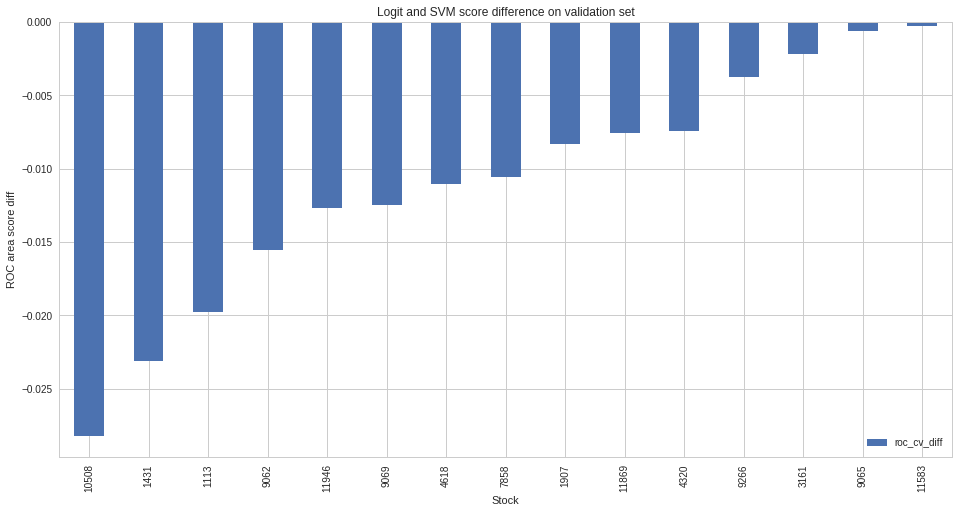

In [27]:
df_worse_train = df_bests[df_bests['roc_cv'] < df_bests['roc_log_cv']]
df_worse_train['roc_cv_diff'] = df_worse_train['roc_cv'] - df_worse_train['roc_log_cv']
df_worse_train = df_worse_train.sort_values(by='roc_cv_diff')

ax = df_worse_train[['roc_cv_diff']].plot(kind='bar', figsize=(16,8))
print('Number of worse stocks on validation set:', len(df_worse_train))
plt.title('Logit and SVM score difference on validation set')
plt.ylabel('ROC area score diff')
plt.xlabel('Stock')

### Can we improve?

Before we took `GDF+SVM`'s with the same $r$ and $\sigma$. It might be that for stocks we underperform we could use different GDF parameteres and get better results.

We will consider results from `df_res` dataframe (described in [data-description](#Data-description)) which have too big difference (so, not in *interdecile range*) between validation score and training score as outliers (because `GDF+SVM`'s with their parameters *overfit* for sure).

In [28]:
def reject_outliers_iqr(df, col='roc_cv', scale=1.5):
    q1, q3 = np.percentile(df[col], [25, 75])
    iqr = q3 - q1

    lower_bound = q1 - (iqr * scale)
    upper_bound = q3 + (iqr * scale)
    print('Length before removing outliers', len(df))
    print('Rejecting items from ', col, 'lower than ', lower_bound, ' and higher than', upper_bound)
    d = df.where((df[col] > lower_bound) & (df[col] < upper_bound))
    d.dropna(inplace=True)
    print('Length after removing outliers', len(d))
    return d

df_res_clean = pd.DataFrame(df_res)
df_res_clean = reject_outliers_iqr(df_res_clean, col='cv_train_diff')

Length before removing outliers 64145
Rejecting items from  cv_train_diff lower than  -0.281597856713  and higher than 0.157846416373
Length after removing outliers 55866


,C,K,gamma,r,roc_cv,roc_train,s,stock,roc_log_cv,roc_log_train,roc_cv_diff,roc_train_diff,cv_train_diff
5,1.0,50.0,1.0,0.07,0.754877,0.611668,0.2,9069.0,0.546371,0.538344,0.208506,0.073324,0.143209
1,1.0,50.0,1.0,0.08,0.754127,0.756669,0.1,1431.0,0.561928,0.546492,0.192199,0.210177,-0.002542
6,1.0,50.0,1.0,0.02,0.734602,0.612537,0.3,4618.0,0.549917,0.544251,0.184685,0.068286,0.122065
8,1.0,50.0,10.0,0.01,0.744244,0.624186,0.4,1907.0,0.563089,0.535701,0.181155,0.088486,0.120058
0,1.0,50.0,1.0,0.02,0.760380,0.629003,0.4,10508.0,0.579272,0.572313,0.181108,0.056690,0.131378
10,1.0,50.0,1.0,0.03,0.755756,0.759049,0.3,4320.0,0.582281,0.561456,0.173475,0.197593,-0.003293
4,1.0,50.0,1.0,0.03,0.748624,0.758379,0.5,11946.0,0.600882,0.581297,0.147743,0.177082,-0.009755
12,10000.0,50.0,1.0,0.05,0.694556,0.537405,0.5,3161.0,0.580808,0.579772,0.113749,-0.042367,0.157151
13,1.0,50.0,1.0,0.02,0.665163,0.584212,0.2,9065.0,0.563017,0.562425,0.102146,0.021787,0.080951
7,1.0,50.0,1.0,0.02,0.654660,0.621098,0.4,7858.0,0.585866,0.572104,0.068794,0.048993,0.033562


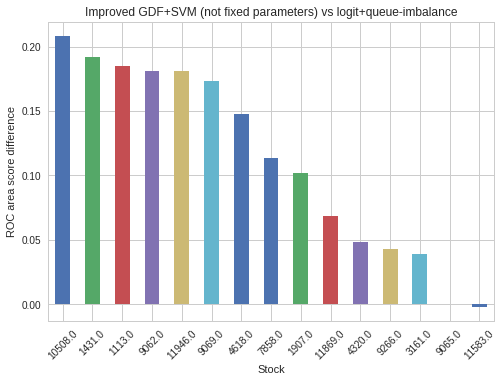

In [29]:
worse_stocks = df_worse_train.index
better_idx = []
df_worse_better = pd.DataFrame(columns=df_res.columns)
for s in worse_stocks:
    row_dict = df_res_clean[df_res_clean['stock'] == int(s)].nlargest(
        1, columns=['roc_cv']).to_dict(orient='records')
    df_worse_better = df_worse_better.append(row_dict, ignore_index=True)

ax = df_worse_better.sort_values(by='roc_cv_diff', ascending=False)['roc_cv_diff'].plot(kind='bar')
_ = ax.set_xticklabels(df_worse_better['stock'], rotation=45)

plt.title('Improved GDF+SVM (not fixed parameters) vs logit+queue-imbalance')
plt.xlabel('Stock')
plt.ylabel('ROC area score difference')
df_worse_better.sort_values(by='roc_cv_diff', ascending=False)

### Results on testing set

Bellow we present results on testing set for `GDF+SVM` approach with the best parameters (so if we were underperforming we pick the best GDF parameters we have seen, otherwise we use fixed ones).

In [30]:
def svm_classification(df, gdf_columns, C=1000, gamma=1):
    clf = SVC(kernel='rbf', C=C, gamma=gamma)
    X = df.loc[:, gdf_columns]
    y = df['mid_price_indicator'].values.reshape(-1, 1)
    y[0] = 0
    clf.fit(X, y)
    return clf

def predict(clf, df, gdf_columns):
    predictions = clf.predict(df.loc[:, gdf_columns])
    try:
        return roc_auc_score(predictions, df['mid_price_indicator'])
    except Exception as e:
        pass
        return -1

In [31]:
stocks = df_bests.index
gdf_columns = ['gdf_' + str(i) for i in range(0, 50)][K1:K2]
dfs = {}
dfs_test = {}
clf = {}
length = 10000
for stock in stocks:
    if stock in worse_stocks:
        r = df_worse_better[df_worse_better['stock'] == stock]['r'].values[0]
        s = df_worse_better[df_worse_better['stock'] == stock]['s'].values[0]
        gamma = df_worse_better[df_worse_better['stock'] == stock]['gamma'].values[0]
        C = df_worse_better[df_worse_better['stock'] == stock]['C'].values[0]
    else:
        r = df_bests.loc[int(stock)]['r']
        s = df_bests.loc[int(stock)]['s']
        gamma = df_bests.loc[int(stock)]['gamma']
        C = df_bests.loc[int(stock)]['C']
    try:
        filename = 'gdf_{}_len{}_r{}_s{}_K{}'.format(stock, length, r, s, K)
        dfs[stock], _, dfs_test[stock] = lob.load_prepared_data(
            filename, data_dir='data_gdf/', cv=True, length=length)

        clf[stock] = svm_classification(dfs[stock], gdf_columns=gdf_columns, C=C, gamma=gamma)
    except Exception as e:
        print(filename, e)
        continue

In [32]:
roc_score = {}
for stock in stocks:
    roc_score[stock] = predict(clf[stock], dfs_test[stock], gdf_columns)

#### GDF+SVM in training validation and test results

It seems that for 3 stocks our prediction failed completely (we predicted only one class), which means that `GDF+SVM` approach is prone to overfitting.

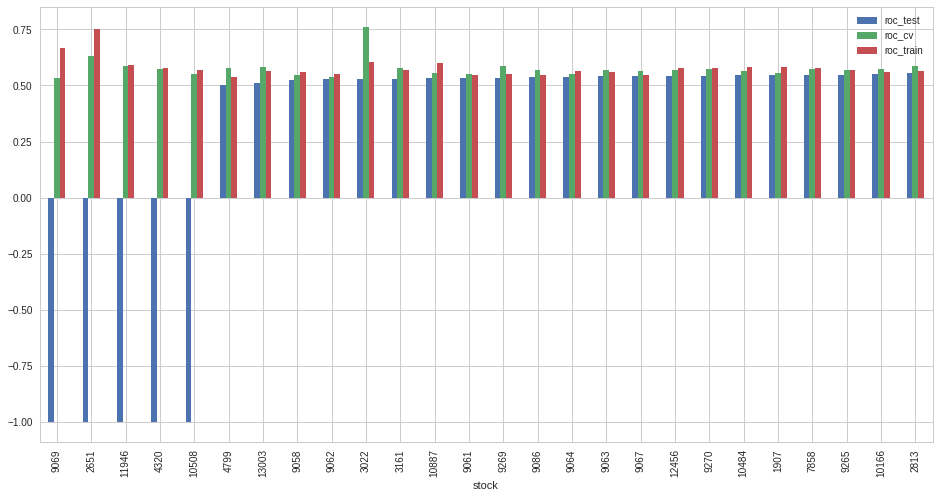

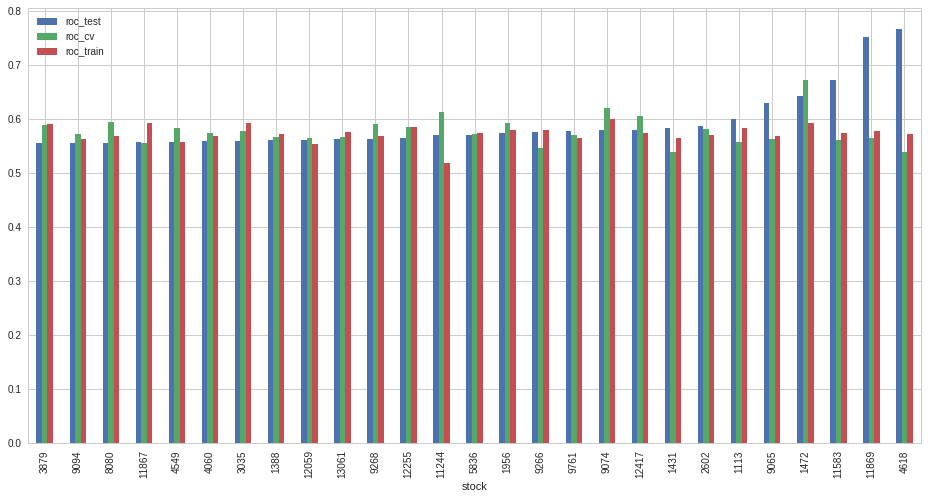

In [33]:
df_bests['roc_test'] = np.zeros(len(df_bests)) - 1
for idx, row in df_bests.iterrows():
    df_bests['roc_test'].loc[idx]= roc_score[idx]

df_bests = df_bests.sort_values(by='roc_test')

ax = df_bests[['roc_test', 'roc_cv', 'roc_train']].iloc[0:len(df_bests)//2].plot(kind='bar', figsize=(16, 8))
ax = df_bests[['roc_test', 'roc_cv', 'roc_train']].iloc[len(df_bests)//2:].plot(kind='bar', figsize=(16, 8))

On average we perform 1% worse on testing set than on validation set:

In [34]:
(df_bests[df_bests['roc_test'] != -1]['roc_test'] - df_bests[df_bests['roc_test'] != -1]['roc_cv']).describe()

count    48.000000
mean     -0.009942
std       0.064162
min      -0.233732
25%      -0.029142
50%      -0.020816
75%      -0.003803
max       0.228368
dtype: float64

#### GDF+SVM vs logit+queue-imbalance on testing set

Approach with `logit+queue-imbalance` always gives some results which is not true for `GDF+SVM`.

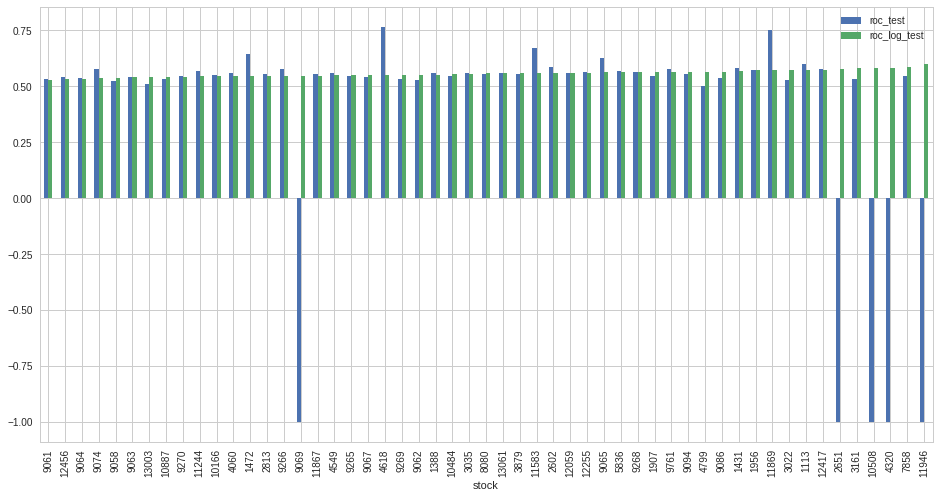

In [35]:
df_bests.reindex()
l = []
for idx, row in df_bests.iterrows():
    l.append(roc_results.result_test_10000[str(idx)])
df_bests.assign(roc_log_test2 = l)
df_bests['roc_log_test'] = np.array(l)

df_bests = df_bests.sort_values(by='roc_log_test')

ax = df_bests[['roc_test', 'roc_log_test']].plot(kind='bar', figsize=(16, 8))

`GDF+SVM` approach is better by 1% on testing set than `logit+queue-imbalance` approach if we consider stocks for which we weren't able to calculate proper predictions as outliers.

In [36]:
(df_bests[df_bests['roc_test'] != -1]['roc_test'] - df_bests[df_bests['roc_test'] != -1]['roc_log_test']).describe()

count    48.000000
mean      0.012101
std       0.049927
min      -0.062554
25%      -0.008482
50%       0.004518
75%       0.012562
max       0.215616
dtype: float64

## Conclusions

In this notebook we used 10 features from datasets converted using `GDF` filters. The results on testing set showed that `GDF+SVM` approach is about 1.2% better than `logit+queue-imbalance` approach to mid-price raise classification problem.

We also noticed that `GDF+SVM` approach might not give results for all stocks, it is prone to *overfitting*. 

The GDF parameters ($r$ and $\sigma$) are crucial in preventing later *overfitting*. We noticed that the best results are for: $r=0.01$ and $\sigma = 0.1$. Intuitivelly it means that the gaussian curve we use for GDF is supposed to be not so wide. Unfortunatelly we didn't perform calculations for $\sigma < 0.1$ - it might be worth to do so.

This approach seems to be a bit worse than approach with 4 features, especially if we consider that for 5 stocks this methodology didn't work.